In [1]:
%load_ext autoreload 
%autoreload 2

import os
import random
from collections import deque
import numpy as np
import scipy.linalg as sl
from PIL import Image
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display

import torch
from torch import nn, distributions as dist, autograd
from torch.func import jacfwd
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, CenterCrop, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, Normalize
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
# torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)
plt.style.use('seaborn-v0_8')

from mnist import MNISTTrain, MNISTTest

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = 28
batch_size = 1024
num_classes = 10

In [3]:
train_ds = MNISTTrain(transform=Compose([
    ToTensor(),
    RandomHorizontalFlip(0.1),
    RandomVerticalFlip(0.1),
    Normalize(127., 128.0)
]))
val_ds = MNISTTest(transform=Compose([
    ToTensor(),
    Normalize(127., 128.0)
]))


In [4]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, drop_last=True)

In [5]:
# class Swish(nn.Module):

#     def forward(self, x):
#         return x * torch.sigmoid(x)

# class Ebm(nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.backbone = nn.Sequential(
#             nn.Conv2d(1, 32, 3, padding=1),
#             # nn.BatchNorm2d(32),
#             Swish(), 
            
#             nn.Conv2d(32, 64, 3, stride=2, padding=1),
#             # nn.BatchNorm2d(64),
#             Swish(), 

#             nn.Conv2d(64, 128, 3, stride=2, padding=1),
#             # nn.BatchNorm2d(128),
#             Swish(), 
            
#             nn.Conv2d(128, 128, 3, stride=2),
#             # nn.BatchNorm2d(128),
#             Swish(), 
            
#             nn.Conv2d(128, 256, 3),
#             # nn.BatchNorm2d(256),
#             Swish(), 
            
            
#         )
#         self.dense = nn.Sequential(
#             nn.Linear(256, 96),
#             Swish(),
#             # nn.Dropout(),
#             nn.Linear(96, 1)
#         )
    
#     def forward(self, x):
#         x = self.backbone(x)
#         x = x.squeeze(-2, -1)
#         x = self.dense(x)
#         return x

In [6]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x**2

In [7]:
ebm = CNNModel()
# ebm(torch.randn((2, 1, 28, 28)))
ebm.cuda()

CNNModel(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
    (1): Swish()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Swish()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Swish()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): Swish()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=64, bias=True)
    (10): Swish()
    (11): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [8]:
class Sampler:
    
    def __init__(self, buffer_size, img_size):
        self.random_sampler = dist.Uniform(-1., 1.)
        self.buffer = deque(maxlen=buffer_size)
        self.buffer_size = buffer_size
        self.buffer.extend(self.random_sampler.sample((self.buffer_size, 1, img_size, img_size)).unbind())
        self.buffer_size = buffer_size
        
    def add(self, x):
        self.buffer.append(x)
        # self.buffer.append(torch.rand((1, img_size, img_size)))
            
    def clear(self):
        self.buffer.clear()

    def sample(self, size):
        random_sample_probs = np.random.binomial(1, 0.05, (size,))
        num_pos = max(1, sum(random_sample_probs))
        for i in range(num_pos):
            self.buffer[i] = self.random_sampler.sample((1, img_size, img_size)) 
        
        idx = np.random.choice(size, size, replace=False)
        
        return [self.buffer[i] for i in idx]

In [9]:
# ebm = torch.load("/mnt/dl/generation/ebm/generation/model/ebm.pth")

In [10]:
# ebm.cuda()

In [11]:
class Trainer:
    
    def __init__(self, model, train_loader, 
                 val_loader=None, epochs=0, 
                 savepath=None, K=1, batch_size=1,
                 grad_step_scale=1., eval_epoch=1000000):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)    
        self.savepath = savepath
        if self.savepath is not None:
            os.makedirs(self.savepath, exist_ok=True)
        self.K = K
        self.batch_size = batch_size
        self.sampler = Sampler(buffer_size=batch_size, 
                                          img_size=img_size)
        self.noise_process = dist.Normal(0., 0.003)
        
        self.lvn_grad_step_scale = grad_step_scale
        self.eval_epoch = eval_epoch
        # self.lvn_clip_grad_norm = 0.01
        self.n_samples = 1
        self.batch_grad_fn = torch.func.vmap(torch.func.grad(self.grad_input_fn))
        
    # def sample_langevin(self, sample_size=-1, return_img_gen=False, steps=-1):
    #     if sample_size == -1:
    #         sample_size = self.batch_size
    #     if steps == -1:
    #         steps = self.K
    #     x = self.replay_buffer.sample(sample_size)
    #     x = x.clip(min=-1, max=1.).clone().detach().cuda()
    #     self.model.eval()
    #     gen_imgs = []
    #     gen_imgs.append(x.clone().detach().cpu())
    #     for k in range(steps):
            
    #         grads_x = self.batch_grad_fn(x)
    #         # Normalize gradient 
    #         # grads_x = grads_x.clamp(min=-0.03, max=0.03)
    #         norm = grads_x.view((x.size(0), -1)).norm(dim=-1, keepdim=True).unsqueeze(-1).unsqueeze(-1)
    #         print(norm[:10], x.view((x.size(0), -1)).norm(dim=-1)[:10])
            
    #         grads_x = grads_x * self.lvn_clip_grad_norm / (norm + 1e-8)
    #         # print(k, norm.max(), grads_x.size(), norm.size())
    #         grads_x = grads_x.clip(min=-0.01, max=0.01)
    #         x = x - self.lvn_grad_step_scale * grads_x + self.noise_process.sample(x.size()).to(torch.device("cuda"))
    #         x = x.clip(min=-1, max=1.)
    #         gen_imgs.append(x.clone().detach().cpu())
        
    #     if return_img_gen:
    #         gen_imgs = torch.stack(gen_imgs, 1)
    #         return gen_imgs
    #     raise Exception
        
    #     self.replay_buffer.clear()
        
    #     for lx in x.unbind():
    #         self.replay_buffer.add(lx.clone().detach().cpu())
        
    #     return x.detach()
    
    def sample_langevin(self, sample_size=-1, return_img_gen=False, steps=-1):
        if sample_size == -1:
            sample_size = self.batch_size
        if steps == -1:
            steps = self.K
        
        sampler_imgs = self.sampler.sample(sample_size)
        x = torch.stack(sampler_imgs).cuda()
        # x = x.clip(min=-1, max=1.).clone().detach().cuda().requires_grad_()
        
        # is_training = self.model.training
        
        self.model.eval()
        gen_imgs = []
        gen_imgs.append(x.clone().detach().cpu())
        
        # for p in self.model.parameters():
        #     p.requires_grad_(False)
        
        with torch.enable_grad():
            for k in range(steps - 1):
                # TODO Change this
                # x.data.copy_(torch.normal(x, 1.0))
                # x[-1].data.copy_(torch.arange(28*28).view((1, 28, 28)))
                # energy = self.model(x)
                # print(energy)
                # loss = energy.sum()
                # loss.backward()
                # print(loss)
                # grad = x.grad.data
                grad = self.batch_grad_fn(x)
                # grad = grad.view((x.size(0), -1))
                # print((grad[0] - grad[-1]).max())
                # print(grad.norm(dim=1)[-10:])
                
                
                # norm = grads_x.view((x.size(0), -1)).norm(dim=-1, keepdim=True).unsqueeze(-1).unsqueeze(-1)
                # print(norm[:10], x.view((x.size(0), -1)).norm(dim=-1)[:10])
                
                # grads_x = grads_x * self.lvn_clip_grad_norm / (norm + 1e-8)
                # print(k, norm.max(), grads_x.size(), norm.size())
                grad = grad.clip(min=-0.03, max=0.03)
                x = x - self.lvn_grad_step_scale * grad + self.noise_process.sample(x.size()).to(torch.device("cuda"))
                x = x.clip(min=-1, max=1.)
                gen_imgs.append(x.clone().detach().cpu())

        # for p in self.model.parameters():
        #     p.requires_grad_(True)

        if return_img_gen:
            gen_imgs = torch.stack(gen_imgs, 1).cpu()
            return gen_imgs
        
        gen_imgs.clear()
        self.sampler.clear()
        for lx in x.unbind():
            self.sampler.add(lx.detach().cpu())
        
        return x.clone().detach()
    
    
    def grad_input_fn(self, x):
        y = self.model(x.unsqueeze(0))
        return y.sum()
        
    def fit(self, epoch, loader):
        losses = []
        for step, (img, label) in enumerate(loader):
            img = img.cuda()
            xgen = self.sample_langevin()
            self.model.train()
            Edata = self.model(img)
            Etheta = self.model(xgen)
            # loss = Edata.mean() - Etheta.mean() +  (Edata.square().mean() + Etheta.square().mean())
            loss = Edata.mean() - Etheta.mean() +  0.1*(Edata.square() + Etheta.square()).mean()
            # print((Edata - Etheta).mean() )
            # print(Edata.square().mean() , Etheta.square().mean())
            # raise Exception
            
            if torch.isnan(loss).item():
                continue
            
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10.)
            self.optimizer.step()
            losses.append(loss.item())

            if step % 15 == 0:
                print(f"Epoch: {epoch}, step: {step}, loss: {np.mean(losses)}")
           
        #    # TODO 
            if step == 250:
                break
        
        return losses
        # return 
    
    def train(self):
        self.train_losses = []
        for epoch in range(1, self.epochs + 1):
            losses = self.fit(epoch, train_loader)
            self.train_losses.extend(losses)
            if epoch % self.eval_epoch == 0:
                self.evaluate(epoch)
                self.generate_imgs(16, )
            # # TODO 
            # break
        
        self.generate_imgs(16)
        return 
    
    def evaluate(self, epoch=None):
        if self.val_loader is None:
            return
        if epoch is None:
            epoch = 0
        # savepath = os.path.join(self.savepath, "evaluation", f"{epoch}")
        # os.makedirs(savepath, exist_ok=True)
        self.model.eval()
        re, fe = 0.0, 0.
        with torch.no_grad():
            k = 0
            for (img, label) in self.val_loader:
                real_img = img.cuda()
                fake_img = torch.rand(real_img.size(0), 1, img_size, img_size).cuda()
                
                real_energy = self.model(real_img)
                fake_energy = self.model(fake_img)
                
                re += real_energy.mean().item()
                fe += fake_energy.mean().item()
                # if k == 5:
                #     break
                # k += 1
        print(f"Evaluation epoch {epoch} loss: {re - fe}, real_energy {re}, fake_energy {fe}")
        self.model.train()
    
    def generate_imgs(self, nsample):
        savepath = os.path.join(self.savepath, f"samples{self.n_samples}")
        os.makedirs(savepath, exist_ok=True)
        with torch.no_grad():
            xgen = self.sample_langevin(sample_size=nsample, return_img_gen=True, steps=256)
            imgs = xgen.permute((0, 1, 3, 4, 2))
            imgs = imgs.squeeze(-1)
            
            imgs *= 128.
            imgs += 127.
            
            imgs = imgs.unbind()
            for n in range(nsample):
                # img_path = os.path.join(savepath, f"{n:03d}")
                # os.makedirs(img_path, exist_ok=True)
                fname = os.path.join(savepath, f"img{n}.jpeg")
                self.save_img(imgs[n], fname)
        self.n_samples += 1
    
    def save_img(self, imgs, fname, timesteps=16):
        length = imgs.shape[0]
        npic = length // timesteps 
        
        nrow = int(np.sqrt(npic))
        ncol = int(np.sqrt(npic))
        fig, axes = plt.subplots(nrows=nrow, ncols=ncol)
        for i in range(nrow):
            for j in range(ncol):
                axes[i, j].imshow(imgs[(i * nrow + j) *npic])
                # axes[i, j].set_xaxis_off()
        fig.savefig(fname)
        plt.close()

In [12]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

mnist_trainer = Trainer(ebm, 
                        train_loader=train_loader, 
                        val_loader=val_loader,
                        epochs=500, 
                        savepath="/mnt/dl/generation/ebm/generation",
                        batch_size=batch_size,
                        grad_step_scale=10.,
                        K=20,
                        eval_epoch=5,
                        )

In [13]:
mnist_trainer.train()

Epoch: 1, step: 0, loss: 0.00011666686623357236
Epoch: 1, step: 15, loss: 7.093409999470168e-05
Epoch: 1, step: 30, loss: 2.395694338936723e-05
Epoch: 1, step: 45, loss: -2.5511821614481565e-05
Epoch: 1, step: 60, loss: -7.719291121903835e-05
Epoch: 1, step: 75, loss: -0.00013310181508299329
Epoch: 1, step: 90, loss: -0.00019556119537650536
Epoch: 1, step: 105, loss: -0.00026695530693428255
Epoch: 1, step: 120, loss: -0.0003486413642469626
Epoch: 1, step: 135, loss: -0.0004424366251782885
Epoch: 1, step: 150, loss: -0.0005501085472211427
Epoch: 1, step: 165, loss: -0.0006740458567086731
Epoch: 1, step: 180, loss: -0.0008149677182047315
Epoch: 1, step: 195, loss: -0.0009747321971111219
Epoch: 1, step: 210, loss: -0.0011540866145245052
Epoch: 1, step: 225, loss: -0.001350481796806028
Epoch: 2, step: 0, loss: -0.0048273708671331406
Epoch: 2, step: 15, loss: -0.005180554959224537
Epoch: 2, step: 30, loss: -0.0055104711002880525
Epoch: 2, step: 45, loss: -0.005896693581472273
Epoch: 2, step

In [14]:
# mnist_trainer.evaluate()

In [15]:
# mnist_trainer.generate_imgs(16)

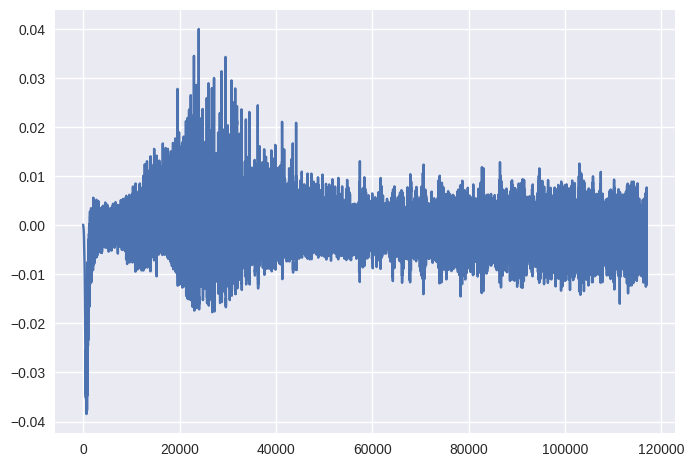

In [16]:
plt.plot(mnist_trainer.train_losses)